In [1]:
import pandas as pd
import numpy as np
import yaml
import sys
import warnings
import ast
import random 


import pandas as pd
import plotly.figure_factory as ff
import plotly.subplots as sp
import plotly.express as px

import plotter as plot
import matplotlib.pyplot as plt

from pathlib import Path

from Stocks import Stock
from Portfolio import Portfolio
import distributions as dt
import returns as rt
import financial_ratios as fr
import optimizers as opt
import numpy as np
import prophet_helpers as ph
import timestamps as ts
import seaborn as sns
import montecarlo as mc


import scipy.stats as stats
from prophet import Prophet
from scipy.stats import lognorm

import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd




warnings.simplefilter(action='ignore')

def read_yaml(file_name): 
    with open(file_name) as file:
        yaml_data= yaml.safe_load(file)
    return yaml_data


def common_random_numbers(size, seed=10):
    np.random.seed(seed)
    return np.random.rand(size)

def plot_multiple_peformance_distributions(performance_of_portfolio_configs_df, combinations, optimization_var, height=None, width=None):
    fig = sp.make_subplots()

    colors = px.colors.qualitative.Plotly

    for i in range(0, len(combinations)):
        combination_str = str(combinations[i])
        temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config'] == combination_str]

        hist_data = [temp_df[optimization_var]]
        group_labels = [combination_str]

        distplot = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
        for trace in distplot['data']:
            trace['line']['color'] = colors[i % len(colors)]
            fig.add_trace(trace)

    fig.update_layout(
        title=f'Distribution of {optimization_var}s across different Portfolio Configurations',
        xaxis_title=f'{optimization_var}',
        yaxis_title='Density',
        legend_title='Portfolio Configurations',
        height=height,
        width=width
    )

    fig.show()


    

def find_best_policy(performance_df, combinations, alpha=0.05, performance_metric='net_return'):
    """
    Find the best policy based on a specified performance metric using the Tukey HSD test.
    
    Parameters
    ----------
    performance_df : pd.DataFrame
        DataFrame containing the performance data of each policy.
    combinations : list
        List of unique policy combinations.
    alpha : float, optional, default: 0.05
        Significance level for the Tukey HSD test.
    performance_metric : str, optional, default: 'net_return'
        The performance metric to use for policy comparison ('net_return' or 'sharpe_ratio').
        
    Returns
    -------
    str
        The best policy based on the specified performance metric.
    """
    # Prepare the data for the Tukey HSD test
    performance_values = []
    policy_labels = []

    for i in range(len(combinations)):
        combination_str = str(combinations[i])
        temp_df = performance_df[performance_df['portfolio_config'] == combination_str]

        performance_values.extend(temp_df[performance_metric].tolist())
        policy_labels.extend([combination_str] * len(temp_df))

    # Perform the Tukey HSD test
    tukey_result = pairwise_tukeyhsd(performance_values, policy_labels, alpha=alpha)

    # Get the list of comparisons with significant differences
    significantly_different_comparisons = [comparison for comparison in tukey_result.reject if comparison]

    # Find the best policy
    best_policy = max(set(policy_labels), key=lambda policy: np.mean([performance_values[i] for i in range(len(performance_values)) if policy_labels[i] == policy]))

    return best_policy

def generate_combinations(step=0.2, target_sum=1.0, num_variables=3, precision=1):
    combinations = []
    num_steps = int(target_sum / step) + 1

    for i in range(num_steps):
        for j in range(num_steps - i):
            k = num_steps - i - j - 1
            if round(i * step, precision) + round(j * step, precision) + round(k * step, precision) == target_sum:
                combinations.append((round(i * step, precision), round(j * step, precision), round(k * step, precision)))

    return combinations


# def simulate_portfolio_value(input_df, combination): 

#     for i in range(0,len(combination)): 
#         input_df[f'weight_{tickers[i]}'] = combination[i]

#     for ticker in tickers: 
#         input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

#     portfolio_values = []
#     for i in range(0,len(input_df)): 
#         portfolio_value = 0
#         for ticker in tickers: 
#             portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
#         portfolio_values.append(portfolio_value)
#     portfolio_values

#     input_df['portfolio_value'] = portfolio_values

#     return input_df

def merge_dfs(dfs): 

    merged_df = dfs[0].copy(deep=True)
    ticker = merged_df['ticker'].iloc[0]
    merged_df.rename(columns={'Close':f'Close_{ticker}'}, inplace=True)

    for i in range(1,len(dfs)): 
        temp_df =dfs[i].copy(deep=True)
        temp_ticker = temp_df['ticker'].iloc[0]
        temp_df.rename(columns={'Close':f'Close_{temp_ticker}'}, inplace=True)


        merged_df = pd.merge(merged_df, temp_df, left_index=True, right_index=True)
        
    return merged_df 




def simulate_portfolio_value(input_df, combination):
    """Simulates the portfolio value for a given combination of weights.

    Args:
        input_df (pandas.DataFrame): A DataFrame containing the price data for each stock in the portfolio.
        combination (tuple): A tuple containing the weights for each stock in the portfolio.

    Returns:
        pandas.DataFrame: The input DataFrame with a new column containing the portfolio value for each row.
    """
    # Add weight columns to the input_df based on the combination
    for i in range(0,len(combination)):
        input_df[f'weight_{tickers[i]}'] = combination[i]

    # Calculate the number of stocks to buy for each stock based on the initial budget and weights
    for ticker in tickers:
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    # Calculate the portfolio value for each row in the input_df
    portfolio_values = []
    for i in range(0,len(input_df)):
        portfolio_value = 0
        for ticker in tickers:
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    input_df['portfolio_value'] = portfolio_values

    # Return the input_df with the new column for portfolio value
    return input_df


def get_choice_resource_allocation_df(choice_dia, choice_qqq, choice_spy, num_trading_days=30):
    """Generates a DataFrame containing the simulated portfolio values and risk measures for different combinations of weights.

    Args:
        choice_dia (float): The weight of DIA (SPDR Dow Jones Industrial Average ETF Trust) in the portfolio.
        choice_qqq (float): The weight of QQQ (Invesco QQQ Trust) in the portfolio.
        choice_spy (float): The weight of SPY (SPDR S&P 500 ETF Trust) in the portfolio.
        num_trading_days (int, optional): The number of trading days to simulate. Default is 30.

    Returns:
        pandas.DataFrame: A DataFrame containing the simulated portfolio values and risk measures for each combination of weights.
    """
    # Get the start date for the simulation
    start_date = pd.to_datetime(dia_df.ticker_data.index)[-1]

    # Get the trading days for the simulation
    trading_days = ts.get_trading_days(start_date, num_trading_days)

    # Simulate the portfolio values for each combination of weights
    simulated_portfolio_values = []
    for i in range(0,len(combinations)):
        sim_df = pd.DataFrame({'date':trading_days,'Close_DIA':choice_dia,  'Close_QQQ': choice_qqq, 'Close_SPY':choice_spy})
        simulated_portfolio_values.append((combinations[i], simulate_portfolio_value(sim_df, combinations[i])['portfolio_value']))

    # Calculate the risk measures for each simulated portfolio value
    simulated_portfolio_values_df_list = []
    for i in range(0,len(simulated_portfolio_values)):
        price_data = simulated_portfolio_values[i][1]
        returns = (price_data / price_data.shift(1)) - 1
        returns = returns.iloc[1:]
        VaR = rt.historical_var(returns, confidence_level=0.95)
        cVaR = rt.historical_cvar(returns, confidence_level=0.95)
        sharpe_ratio = fr.get_sharpe_ratio(returns, risk_free_rate=0.02)
        sortino_ratio = fr.get_sortino_ratio(returns, risk_free_rate=0.02)

        simulated_portfolio_values_df_list.append(pd.DataFrame({'portfolio_config':[str(simulated_portfolio_values[i][0])], \
                                                                'mean':[np.mean(simulated_portfolio_values[i][1])], \
                                                                'var':[np.var(simulated_portfolio_values[i][1])], \
                                                                'std':[np.std(simulated_portfolio_values[i][1])],\
                                                                'VaR':[VaR], 'cVaR':[cVaR], 'sharpe_ratio':[sharpe_ratio],\
                                                                'sortino_ratio':[sortino_ratio]
                                                               }))

    # Combine the risk measures for each simulated portfolio value into a single DataFrame
    simulated_portfolio_values_df = pd.concat(simulated_portfolio_values_df_list)

    # Calculate the net return for each simulated portfolio value
    simulated_portfolio_values_df['net_return'] = (simulated_portfolio_values_df['mean']-initial_budget)/initial_budget

    # Return the DataFrame with the simulated portfolio values and risk measures
    return simulated_portfolio_values_df




def adjust_weights(weights, min_weight, max_weight):
    """Adjusts the weights tuple such that no stock is given 0% but all weights add up to 100%.

    Args:
        weights (tuple): A tuple representing the weight allocation for three stocks.
        min_weight (float): The minimum weight that any stock can have.
        max_weight (float): The maximum weight that any stock can have.

    Returns:
        tuple: The adjusted weight allocation tuple.
    """
    # Convert the weights tuple to a list so that we can modify it
    weights_list = list(weights)

    # Count the number of non-zero weights
    num_nonzero_weights = sum([1 for w in weights_list if w > 0])

    # If all weights are zero, set them all to the minimum
    if num_nonzero_weights == 0:
        weights_list = [min_weight] * len(weights_list)
        weights_list[0] += 1 - sum(weights_list)
    else:
        # Adjust the non-zero weights so that they add up to 100%
        total_nonzero_weight = sum([w for w in weights_list if w > 0])
        for i in range(len(weights_list)):
            if weights_list[i] > 0:
                weights_list[i] *= (1.0 / total_nonzero_weight)

        # Set any weight less than the minimum to the minimum
        for i in range(len(weights_list)):
            if weights_list[i] < min_weight:
                weights_list[i] = min_weight

        # Set any weight greater than the maximum to the maximum
        for i in range(len(weights_list)):
            if weights_list[i] > max_weight:
                weights_list[i] = max_weight

        # Adjust the zero weights so that they add up to 100%
        total_zero_weight = sum([w for w in weights_list if w == 0])
        if total_zero_weight > 0:
            for i in range(len(weights_list)):
                if weights_list[i] == 0:
                    weights_list[i] = (1.0 - total_nonzero_weight) / total_zero_weight

    # Convert the weights list back to a tuple and return it
    return tuple(weights_list)



config = read_yaml('config.yaml')
# config['canadian_etfs_parsed']
canadian_etfs_parsed = config['canadian_etfs_parsed']
canadian_etfs_parsed



['VFV.TO']

<img src="Dataset_info.png" alt="Screenshot" width="800" height='400'/>

In [2]:
np.random.seed(10)

# Data Loading 

In [3]:
# start_dt = '2011-01-03'
# end_dt= '2015-04-13'

initial_budget =10000

training_start_dt = '2015-01-01'
training_end_dt = '2020-12-31'

test_start_dt = '2021-01-01' 
test_end_dt = '2021-12-31'

out_of_sample_start_dt = '2022-01-01'
out_of_sample_end_dt = '2022-12-31'
tickers=[ 'DIA', 'QQQ', 'SPY' ]

dia_df = Stock('DIA', training_start_dt, training_end_dt)
# dia_df.ticker_data['ticker'] = 'diaA'

spy_df= Stock('SPY',training_start_dt, training_end_dt)
# spy_df.ticker_data['ticker'] = 'SPY'

qqq_df = Stock('QQQ', training_start_dt, training_end_dt)
# qqq_df.ticker_data['ticker'] = 'QQQ'



dfs = [dia_df.ticker_data,spy_df.ticker_data, qqq_df.ticker_data]
merged_df =merge_dfs(dfs)
merged_df.head()

Pulling from yahoo
[*********************100%***********************]  1 of 1 completed
Pulling from yahoo
[*********************100%***********************]  1 of 1 completed
Pulling from yahoo
[*********************100%***********************]  1 of 1 completed


Open_x      High_x       Low_x   Close_DIA  Volume_x ticker_x  \
2015-01-02  178.649994  179.229996  176.979996  177.940002   4997200      DIA   
2015-01-05  177.059998  177.210007  174.460007  174.839996   6700200      DIA   
2015-01-06  175.100006  175.539993  172.320007  173.389999  10131400      DIA   
2015-01-07  174.850006  175.789993  174.240005  175.589996   5547000      DIA   
2015-01-08  177.259995  178.960007  177.210007  178.759995   7166700      DIA   

            pct_change_x  Cumulative_Percentage_Change_x  normalized_close_x  \
2015-01-02           NaN                        0.000000            0.145286   
2015-01-05     -0.017422                       -1.742164            0.124289   
2015-01-06     -0.008293                       -2.557043            0.114468   
2015-01-07      0.012688                       -1.320673            0.129369   
2015-01-08      0.018053                        0.460825            0.150840   

            cumulative_mean_normalized_close_x  ...  pct_change  \
2015-01-02                            0.145286  ...         NaN   
2015-01-05                            0.134787  ...   -0.014669   
2015-01-06                            0.128014  ...   -0.013408   
2015-01-07                            0.128353  ...    0.012891   
2015-01-08                            0.132850  ...    0.019140   

            Cumulative_Percentage_Change  normalized_close  \
2015-01-02                      0.000000          0.030556   
2015-01-05                     -1.466876          0.023586   
2015-01-06                     -2.788034          0.017309   
2015-01-07                     -1.534876          0.023263   
2015-01-08                      0.349719          0.032218   

            cumulative_mean_normalized_close  \
2015-01-02                          0.030556   
2015-01-05                          0.027071   
2015-01-06                          0.023817   
2015-01-07                          0.023679   
2015-01-08                          0.025387   

            cumulative_variance_normalized_close  \
2015-01-02                              0.000000   
2015-01-05                              0.000012   
2015-01-06                              0.000029   
2015-01-07                              0.000022   
2015-01-08                              0.000029   

            cumulative_std_normalized_close      skew   kurtosis  \
2015-01-02                         0.000000 -0.549863  10.113303   
2015-01-05                         0.003485 -0.549863  10.113303   
2015-01-06                         0.005411 -0.549863  10.113303   
2015-01-07                         0.004692 -0.549863  10.113303   
2015-01-08                         0.005411 -0.549863  10.113303   

            Jarque_Bera_stat  Jarque_Bera_p_val  
2015-01-02       6511.138584                0.0  
2015-01-05       6511.138584                0.0  
2015-01-06       6511.138584                0.0  
2015-01-07       6511.138584                0.0  
2015-01-08       6511.138584                0.0  

[5 rows x 48 columns]

In [4]:
min_retrieve_dt = dia_df.ticker_data.index.min()
max_retrieve_dt = dia_df.ticker_data.index.max()
min_retrieve_dt, max_retrieve_dt

('2015-01-02', '2020-12-30')

# Portfolio Creation and Summary Statistics

In [5]:
p = Portfolio(tickers=[ 'DIA', 'QQQ', 'SPY' ], start_dt=min_retrieve_dt, end_dt=max_retrieve_dt)
cm = sns.light_palette("green", as_cmap=True) 
p.summary_statistics.style.background_gradient(cmap=cm)

Pulling from yahoo
[*********************100%***********************]  1 of 1 completed
Pulling from yahoo
[*********************100%***********************]  1 of 1 completed
Pulling from yahoo
[*********************100%***********************]  1 of 1 completed


In [6]:
p.correlation_matrix.style.background_gradient(cmap=cm)

In [7]:
df = p.all_stocks_df.copy(deep=True)
df.head()

Open        High         Low       Close    Volume ticker  \
2015-01-02  178.649994  179.229996  176.979996  177.940002   4997200    DIA   
2015-01-05  177.059998  177.210007  174.460007  174.839996   6700200    DIA   
2015-01-06  175.100006  175.539993  172.320007  173.389999  10131400    DIA   
2015-01-07  174.850006  175.789993  174.240005  175.589996   5547000    DIA   
2015-01-08  177.259995  178.960007  177.210007  178.759995   7166700    DIA   

            pct_change  Cumulative_Percentage_Change  normalized_close  \
2015-01-02         NaN                      0.000000          0.145414   
2015-01-05   -0.017422                     -1.742164          0.124398   
2015-01-06   -0.008293                     -2.557043          0.114568   
2015-01-07    0.012688                     -1.320673          0.129483   
2015-01-08    0.018053                      0.460825          0.150973   

            cumulative_mean_normalized_close  \
2015-01-02                          0.145414   
2015-01-05                          0.134906   
2015-01-06                          0.128127   
2015-01-07                          0.128466   
2015-01-08                          0.132967   

            cumulative_variance_normalized_close  \
2015-01-02                              0.000000   
2015-01-05                              0.000110   
2015-01-06                              0.000166   
2015-01-07                              0.000124   
2015-01-08                              0.000181   

            cumulative_std_normalized_close      skew  kurtosis  \
2015-01-02                         0.000000 -0.693342  21.99382   
2015-01-05                         0.010508 -0.693342  21.99382   
2015-01-06                         0.012866 -0.693342  21.99382   
2015-01-07                         0.011157 -0.693342  21.99382   
2015-01-08                         0.013440 -0.693342  21.99382   

            Jarque_Bera_stat  Jarque_Bera_p_val  
2015-01-02       30535.30748                0.0  
2015-01-05       30535.30748                0.0  
2015-01-06       30535.30748                0.0  
2015-01-07       30535.30748                0.0  
2015-01-08       30535.30748                0.0

In [8]:
df.index.min(),df.index.max(), min_retrieve_dt, max_retrieve_dt

('2015-01-02', '2020-12-29', '2015-01-02', '2020-12-30')

### Generate Combinations 

In [9]:
combinations = generate_combinations()
combinations_df = pd.DataFrame(combinations, columns=tickers)
combinations_df

DIA  QQQ  SPY
0   0.0  0.0  1.0
1   0.0  0.2  0.8
2   0.0  0.4  0.6
3   0.0  0.6  0.4
4   0.0  0.8  0.2
5   0.0  1.0  0.0
6   0.2  0.0  0.8
7   0.2  0.2  0.6
8   0.2  0.4  0.4
9   0.2  0.6  0.2
10  0.2  0.8  0.0
11  0.4  0.0  0.6
12  0.4  0.2  0.4
13  0.4  0.4  0.2
14  0.4  0.6  0.0
15  0.6  0.0  0.4
16  0.6  0.2  0.2
17  0.6  0.4  0.0
18  0.8  0.0  0.2
19  0.8  0.2  0.0
20  1.0  0.0  0.0

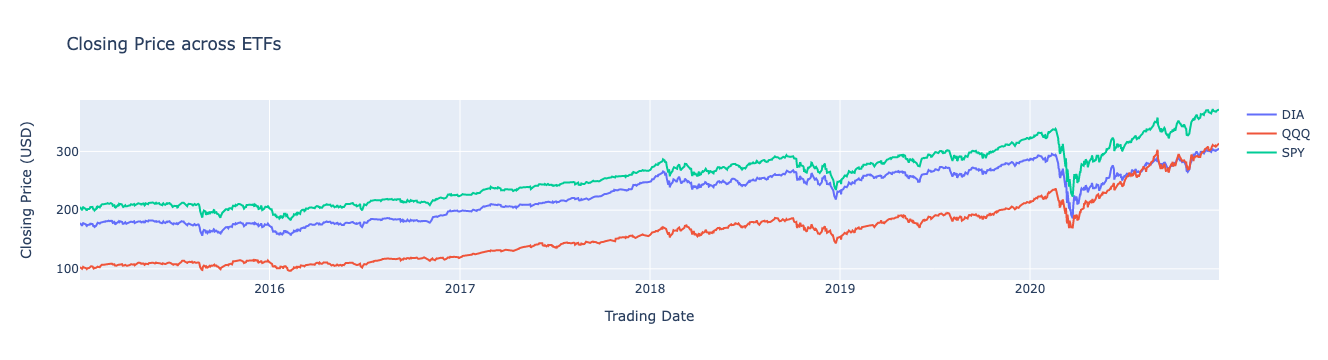

In [10]:
plot.plot_column_across_tickers(df, col_name = 'Close', title='Closing Price across ETFs', yaxis_title='Closing Price (USD)', xaxis_title='Trading Date')

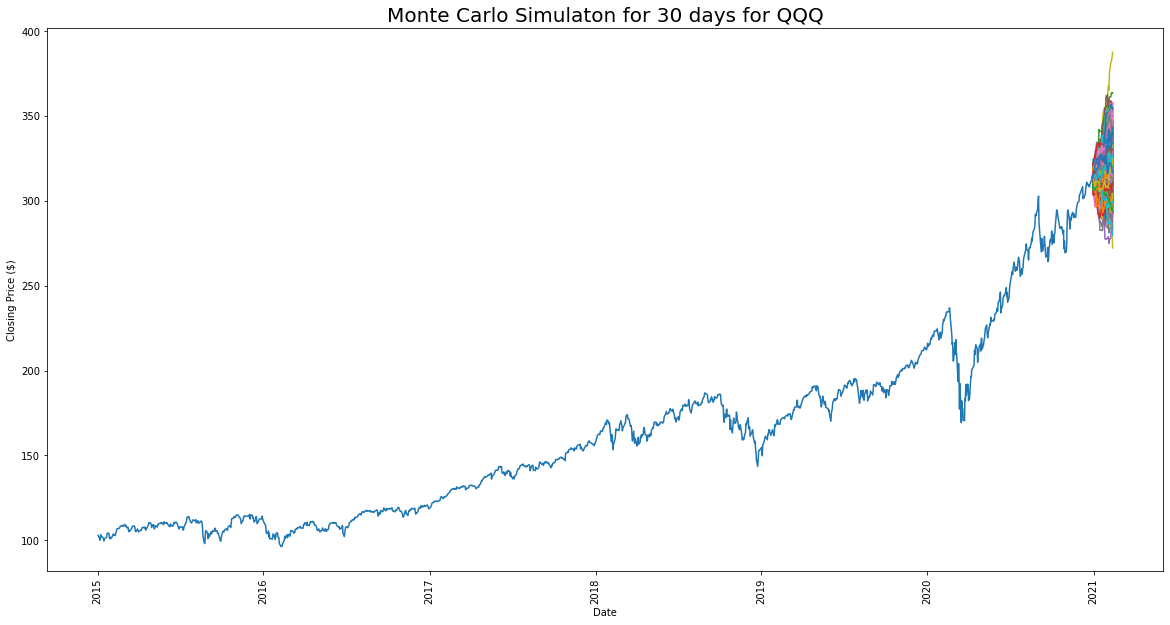

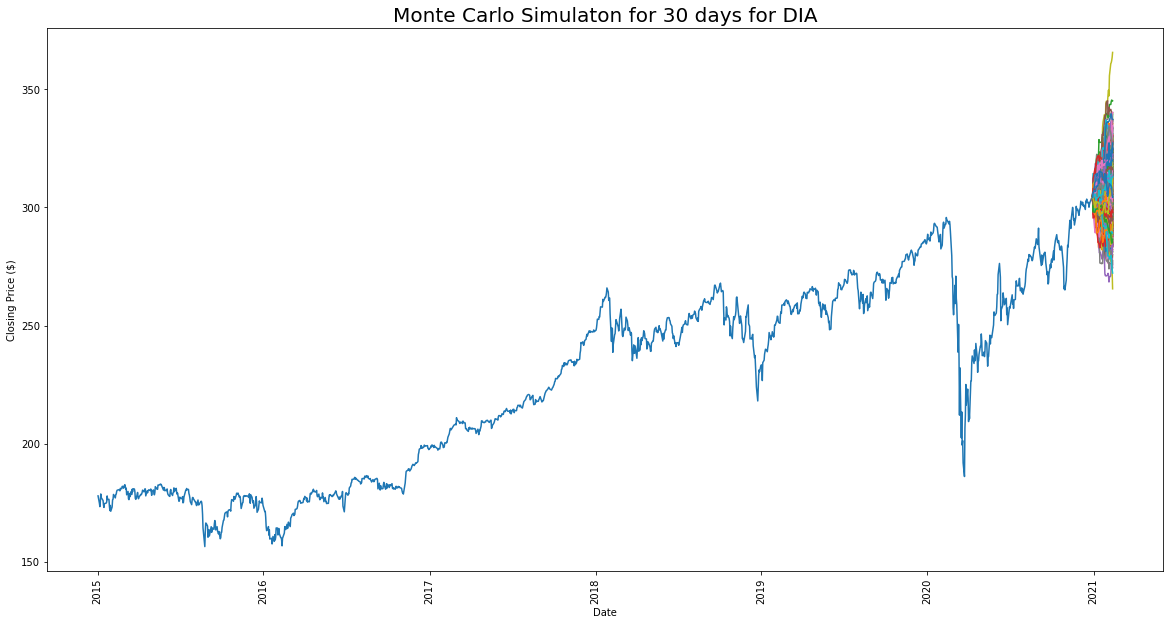

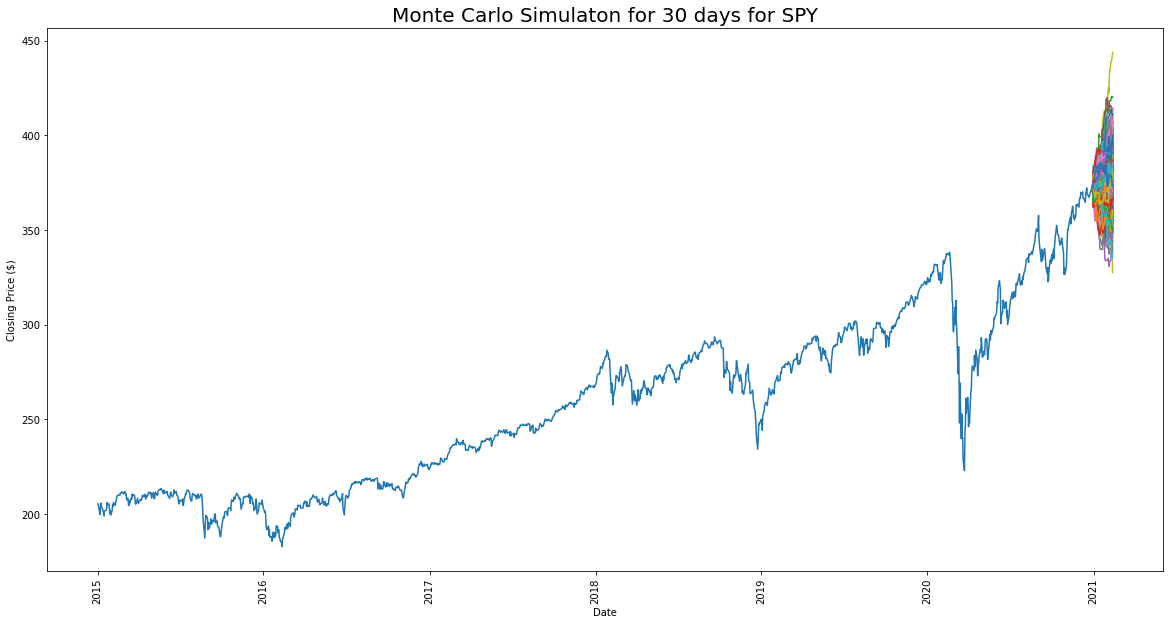

In [11]:

qqq_paths = mc.plot_montecarlo_paths(qqq_df.ticker_data['pct_change'].iloc[1:], qqq_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for QQQ',ylabel='Closing Price ($)', xlabel='Date' )

dia_paths = mc.plot_montecarlo_paths(dia_df.ticker_data['pct_change'].iloc[1:], dia_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for DIA',ylabel='Closing Price ($)', xlabel='Date' )

spy_paths = mc.plot_montecarlo_paths(spy_df.ticker_data['pct_change'].iloc[1:], spy_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for SPY',ylabel='Closing Price ($)', xlabel='Date' )

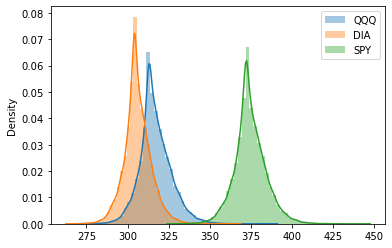

In [12]:
sns.distplot(qqq_paths, label='QQQ')
sns.distplot(dia_paths, label='DIA')
sns.distplot(spy_paths, label='SPY')
plt.legend()

### Chose a sample predicted path for each of the stocks, try out each of the portfolio distributions, see which one has the highest Sharpe Ratio.  
### Choose that distribution. 

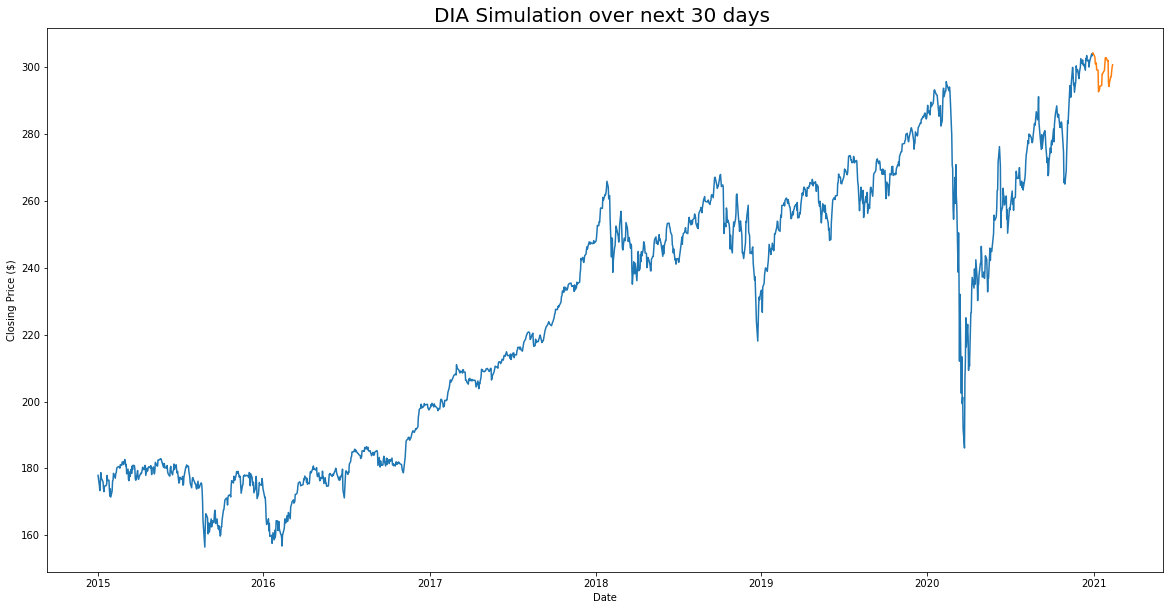

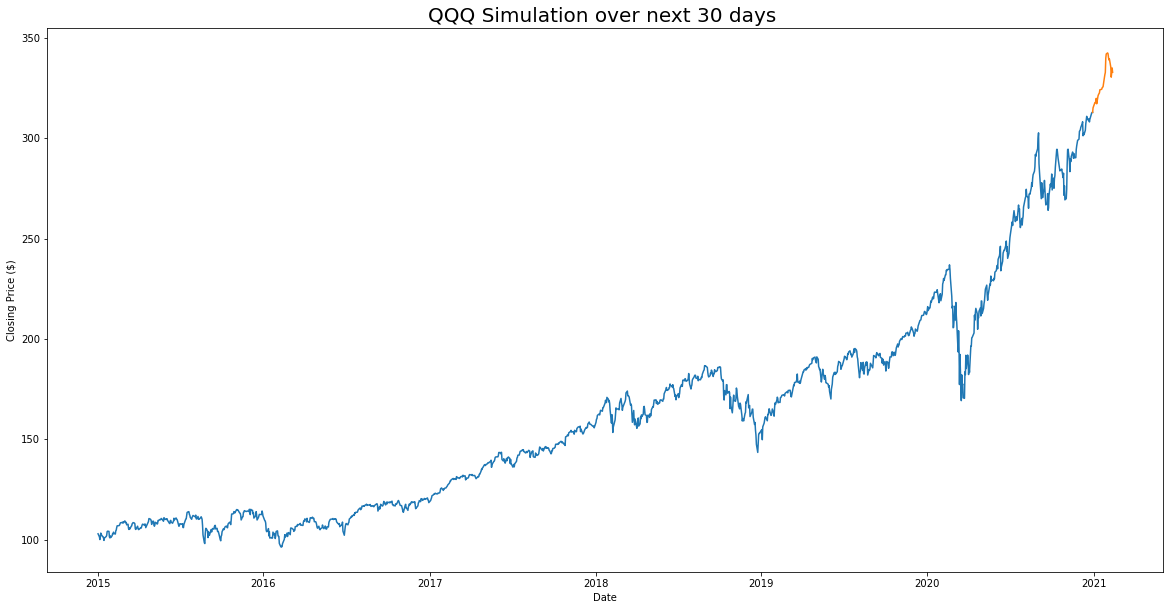

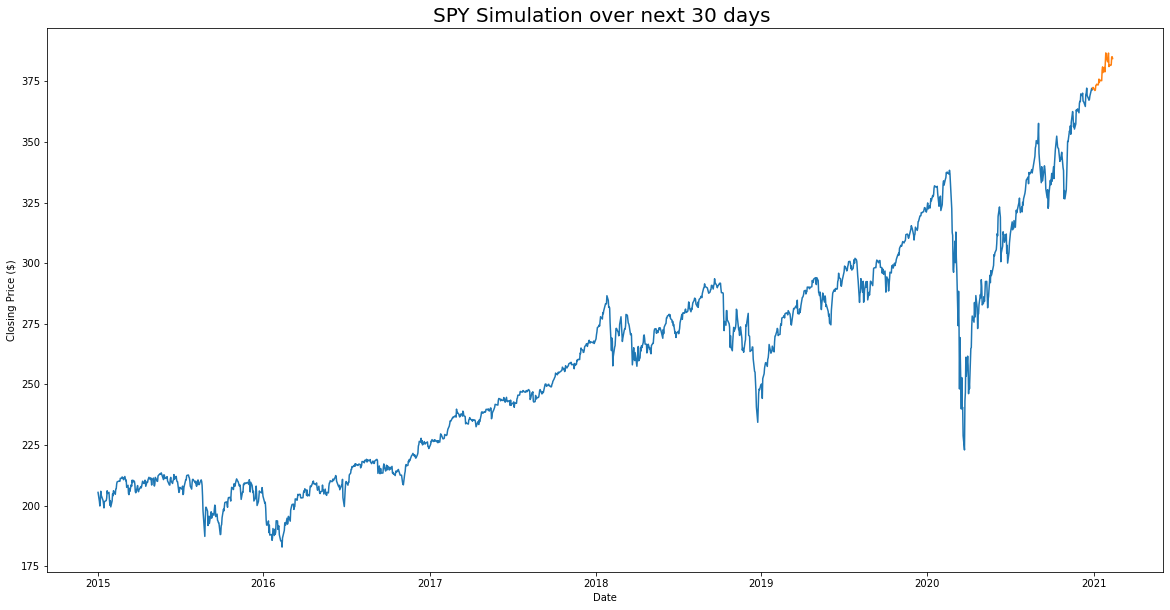

In [13]:

choice_dia = random.choice(dia_paths)
choice_qqq = random.choice(qqq_paths)
choice_spy = random.choice(spy_paths)

mc.plot_possible_mc_path_extension(dia_df.ticker_data, choice_dia, title='DIA Simulation over next 30 days ', xlabel='Date', ylabel='Closing Price ($)')
mc.plot_possible_mc_path_extension(qqq_df.ticker_data, choice_qqq, title='QQQ Simulation over next 30 days ', xlabel='Date', ylabel='Closing Price ($)')
mc.plot_possible_mc_path_extension(spy_df.ticker_data, choice_spy, title='SPY Simulation over next 30 days ', xlabel='Date', ylabel='Closing Price ($)')

df = get_choice_resource_allocation_df(choice_dia, choice_qqq, choice_spy, num_trading_days=len(choice_dia))

### Inputs: random numbers, dia_path, qqq_paths, spy_paths 
### Outputs: a list of dataframes that contains the performance measures of each of the portfolio configurations across each of those paths

In [14]:
crn_choices = [int(x.round(2)*100) for x in common_random_numbers(1000, seed=10)]

simulations_over_month = []

for i in range(0,1000): 
    if i%50==0: 
        print(i)
    choice_dia = dia_paths[crn_choices[i]]
    choice_qqq = qqq_paths[crn_choices[i]]
    choice_spy = spy_paths[crn_choices[i]]

    simulations_over_month.append(get_choice_resource_allocation_df(choice_dia, choice_qqq, choice_spy, num_trading_days=len(choice_dia)))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


### Input: a list of dataframes that contains the performance measures of each of the portfolio configurations across each of those paths
### outputs: 
    * A plot of the distribution of each of the performance of measures for each portfolio configuration across each of those 1000 paths
    * The best policy based on net return and the best policy based on sharpe ratio

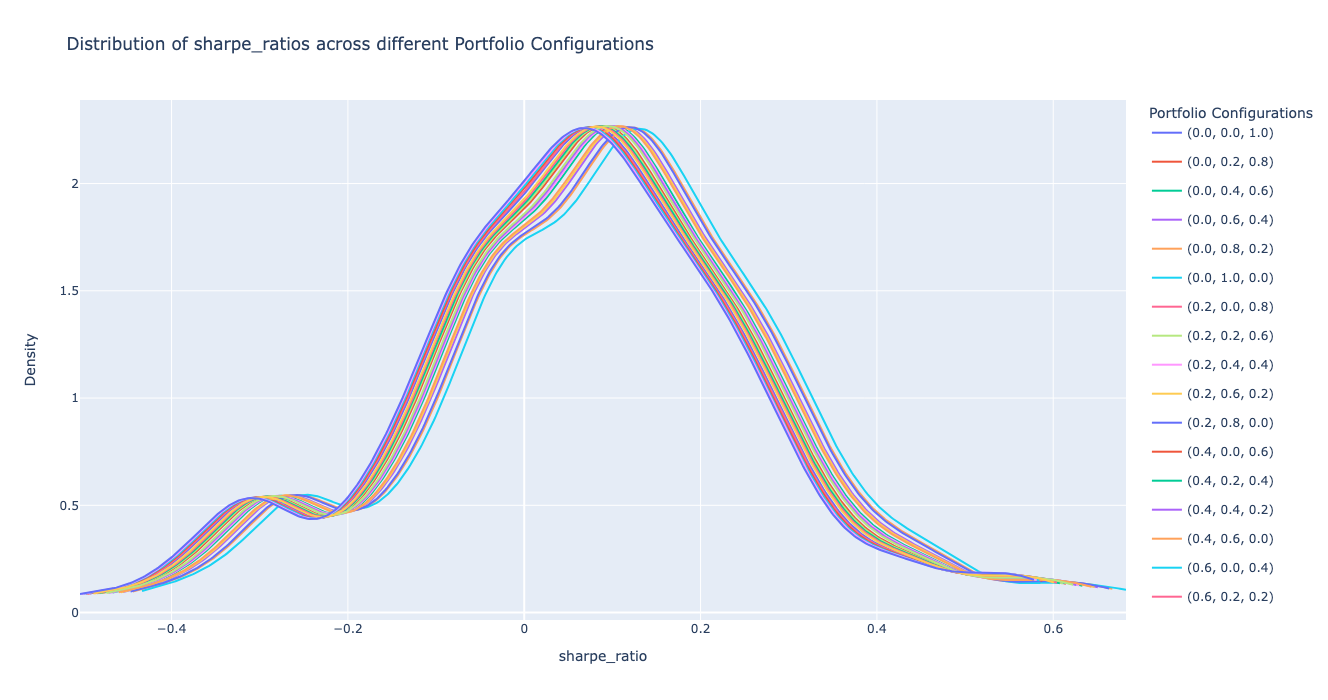

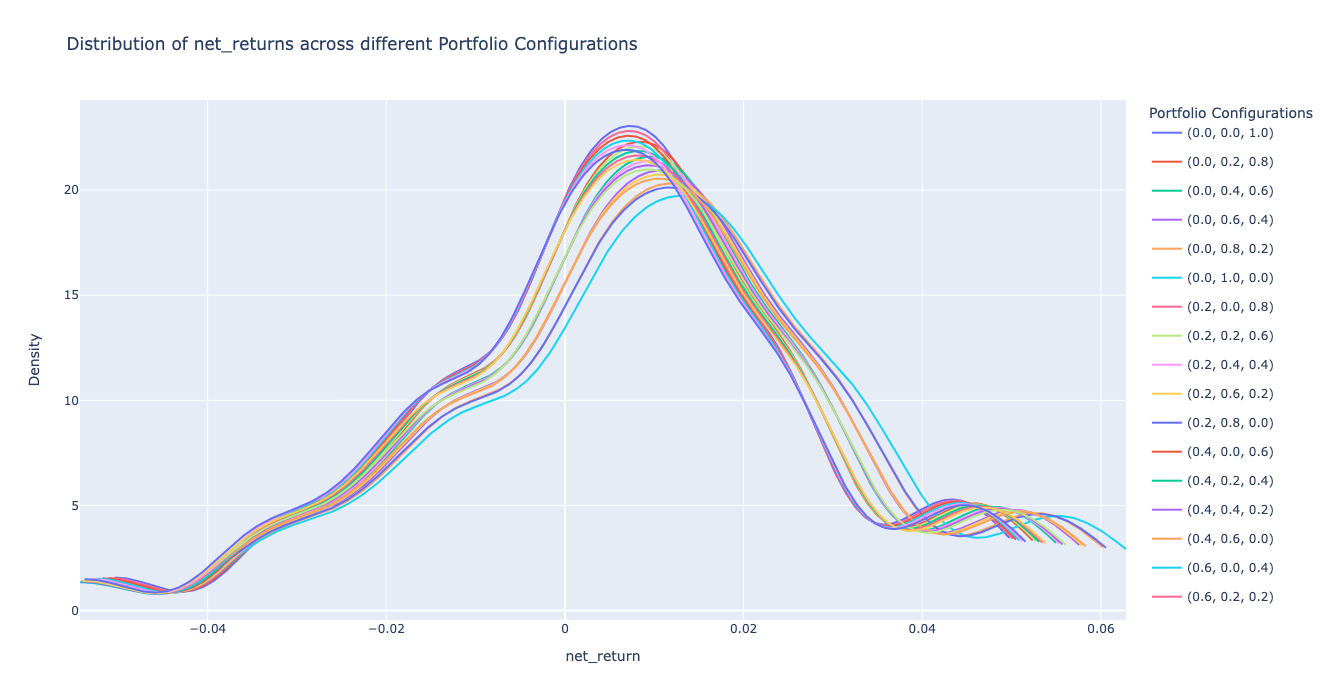

Best policy based on Sharpe Ratio: (0.0, 1.0, 0.0)
Best policy based on net return: (0.0, 1.0, 0.0)


In [15]:
performance_of_portfolio_configs_df = pd.concat(simulations_over_month)
plot_multiple_peformance_distributions(performance_of_portfolio_configs_df, combinations, 'sharpe_ratio', height=700, width=1200)
plot_multiple_peformance_distributions(performance_of_portfolio_configs_df, combinations, 'net_return', height=700, width=1200)

best_policy_sharpe_ratio = find_best_policy(performance_of_portfolio_configs_df, combinations, performance_metric='sharpe_ratio')
best_policy_sharpe_ratio = ast.literal_eval(best_policy_sharpe_ratio)
print("Best policy based on Sharpe Ratio:", best_policy_sharpe_ratio)

best_policy_net_return = find_best_policy(performance_of_portfolio_configs_df, combinations, performance_metric='net_return')
best_policy_net_return = ast.literal_eval(best_policy_net_return)
print("Best policy based on net return:", best_policy_net_return)

### Sanity Check - Seeing that the best policy is in agreement with a quick visualization of the closing prices of the stock

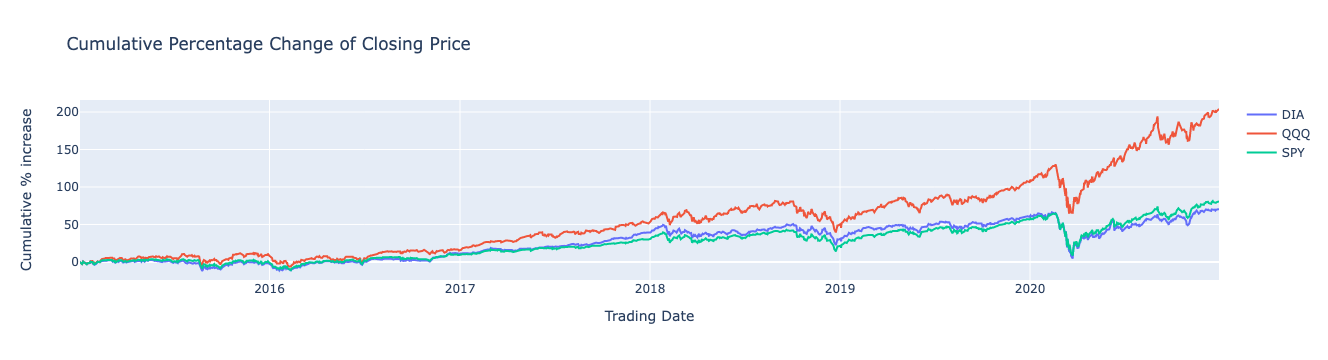

In [16]:
df = p.all_stocks_df.copy(deep=True)
plot.plot_column_across_tickers(df, col_name = 'Cumulative_Percentage_Change', title='Cumulative Percentage Change of Closing Price', xaxis_title='Trading Date', yaxis_title='Cumulative % increase')

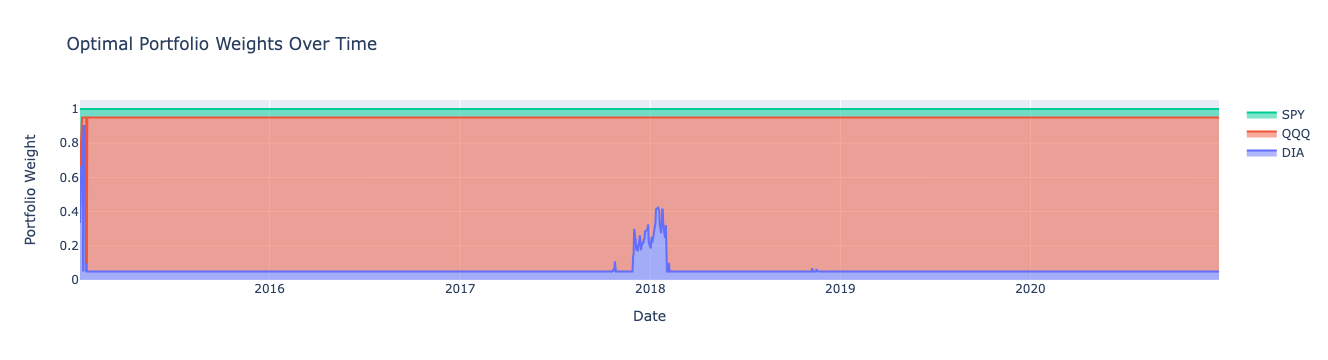

In [17]:
min_weight = 0.05
max_weight = 0.95

# Annual risk-free rate
annual_risk_free_rate = 0.02
# Convert annual risk-free rate to daily rate
daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1


unique_dates = list(set(merged_df.index))
unique_dates.sort()

moving_optimal_weights = []

for N in range(2,len(unique_dates)): 
    DIA = list(dia_df.ticker_data['pct_change'].iloc[1:N])
    QQQ = list(qqq_df.ticker_data['pct_change'].iloc[1:N])
    SPY = list(spy_df.ticker_data['pct_change'].iloc[1:N])

    # Calculate mean returns and covariance matrix
    returns = np.array([DIA, QQQ, SPY])
    mean_returns = np.mean(returns, axis=1)

    cov_matrix = np.cov(returns)
       
    # Perform optimization
    num_stocks = len(mean_returns)
    optimal_weights = opt.maximize_sharpe_ratio(mean_returns, cov_matrix, daily_risk_free_rate, num_stocks, min_weight, max_weight)

    moving_optimal_weights.append(optimal_weights.x)

area_plot = plot.create_area_plot(moving_optimal_weights, tickers, unique_dates)
area_plot.show()



In [18]:
best_policy_net_return_adjusted = adjust_weights(best_policy_net_return, 0.1, 0.8)
best_policy_sharpe_ratio_adjusted = adjust_weights(best_policy_sharpe_ratio, 0.1, 0.8)
best_policy_net_return_adjusted, best_policy_sharpe_ratio_adjusted

((0.1, 0.8, 0.1), (0.1, 0.8, 0.1))

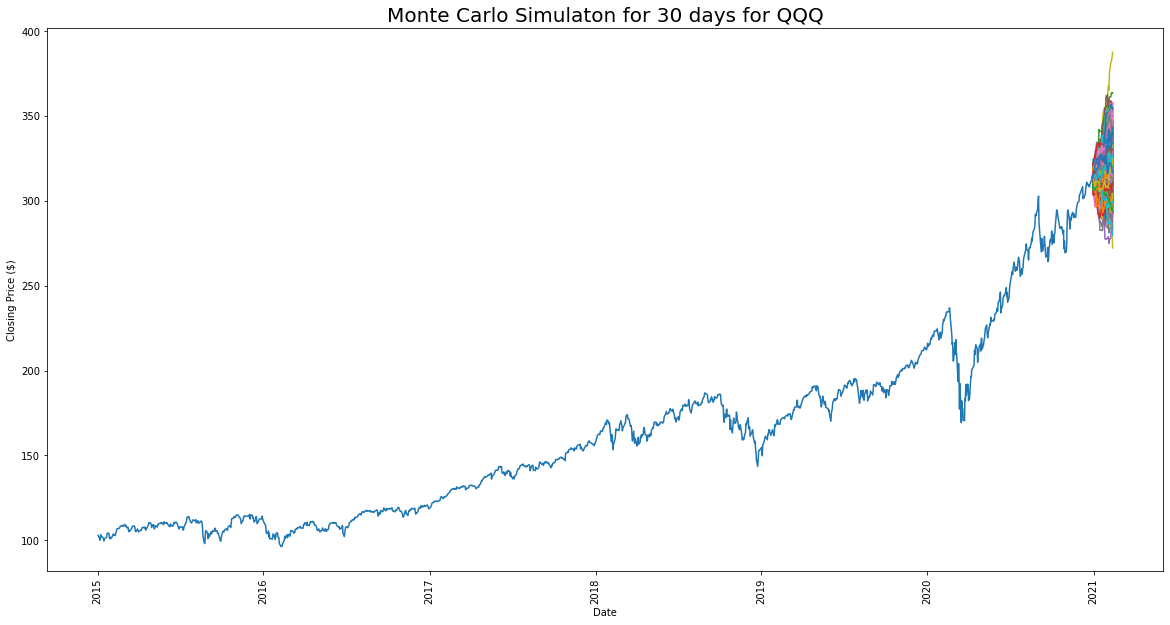

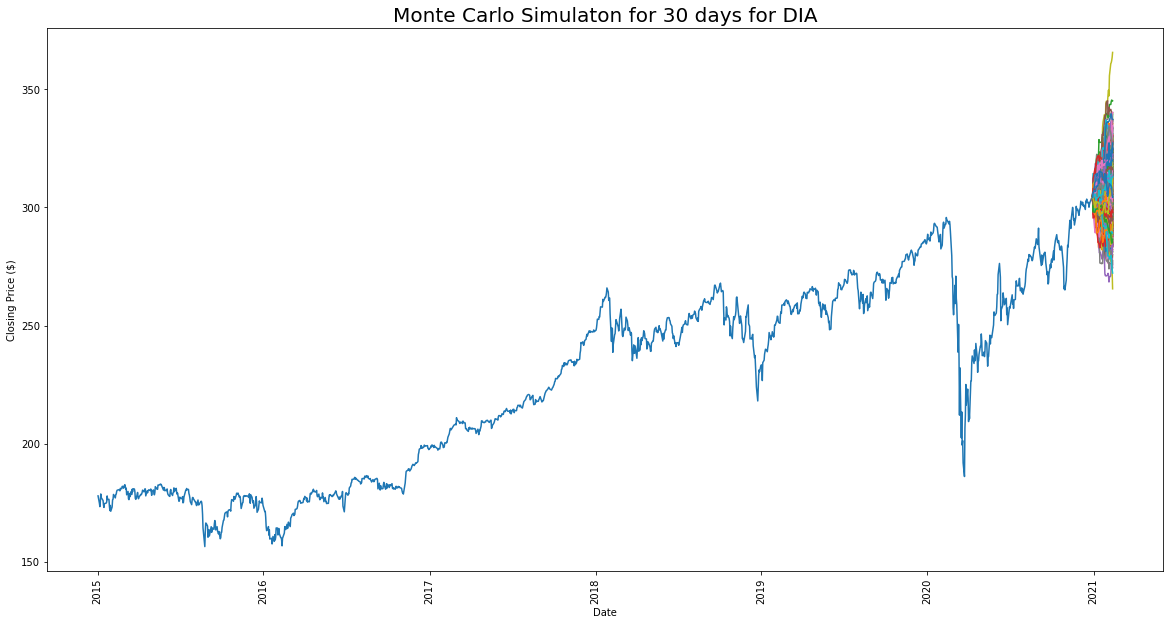

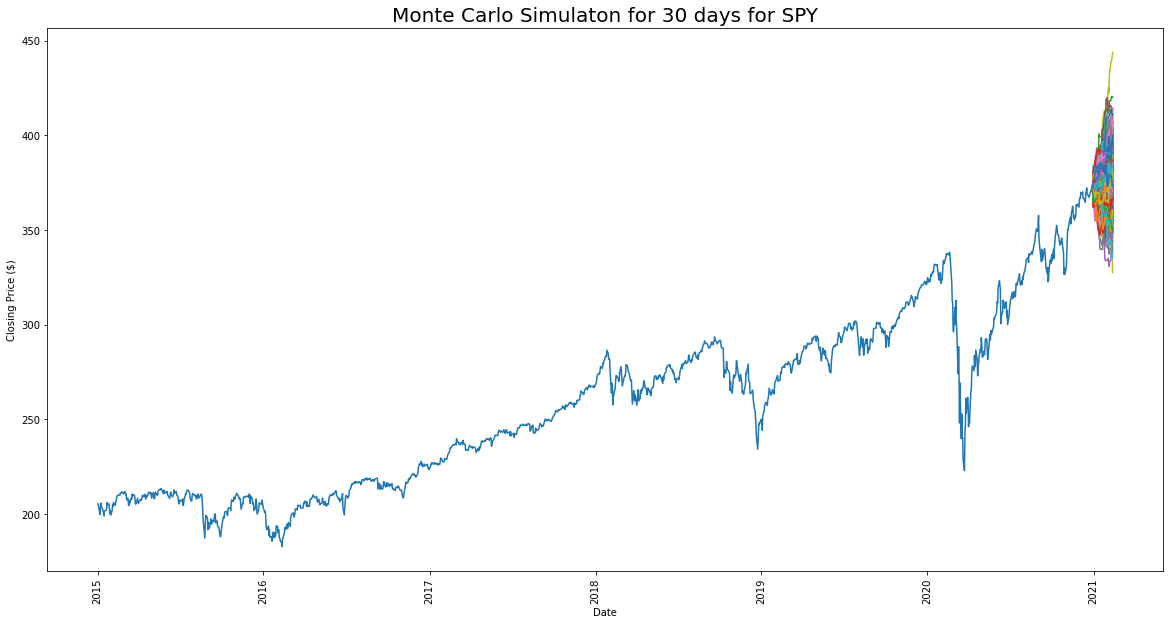

In [19]:

qqq_paths = mc.plot_montecarlo_paths(qqq_df.ticker_data['pct_change'].iloc[1:], qqq_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for QQQ',ylabel='Closing Price ($)', xlabel='Date' )

dia_paths = mc.plot_montecarlo_paths(dia_df.ticker_data['pct_change'].iloc[1:], dia_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for DIA',ylabel='Closing Price ($)', xlabel='Date' )

spy_paths = mc.plot_montecarlo_paths(spy_df.ticker_data['pct_change'].iloc[1:], spy_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for SPY',ylabel='Closing Price ($)', xlabel='Date' )

In [20]:
best_policy_net_return_adjusted, best_policy_sharpe_ratio_adjusted


((0.1, 0.8, 0.1), (0.1, 0.8, 0.1))

In [21]:
qqq_df.ticker_data['Close'].iloc[-1]

312.9700012207031

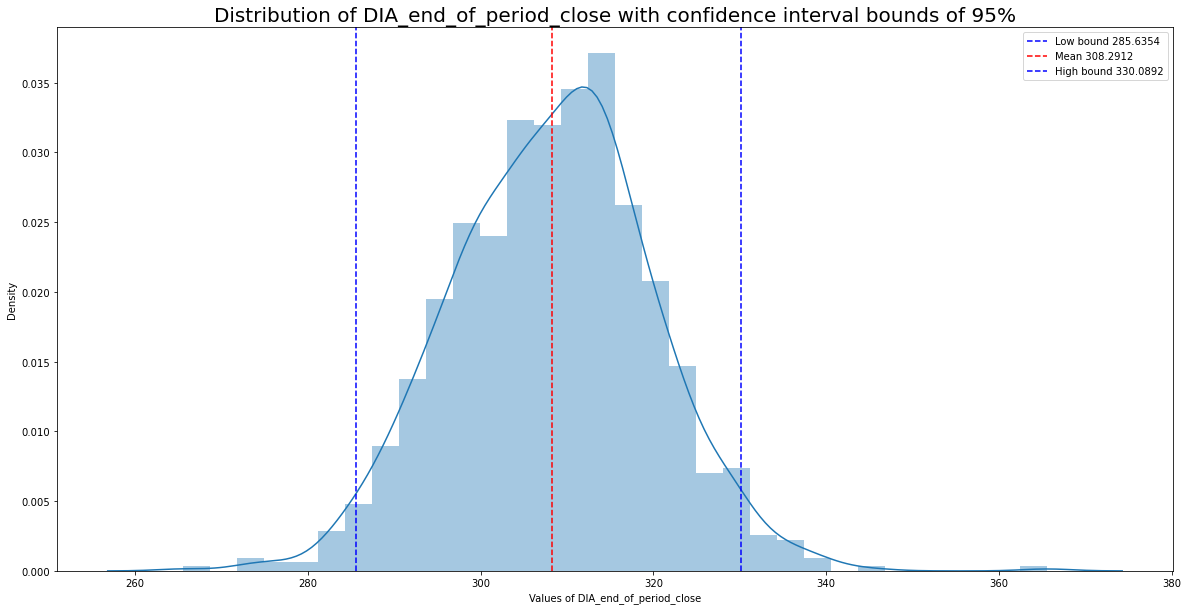

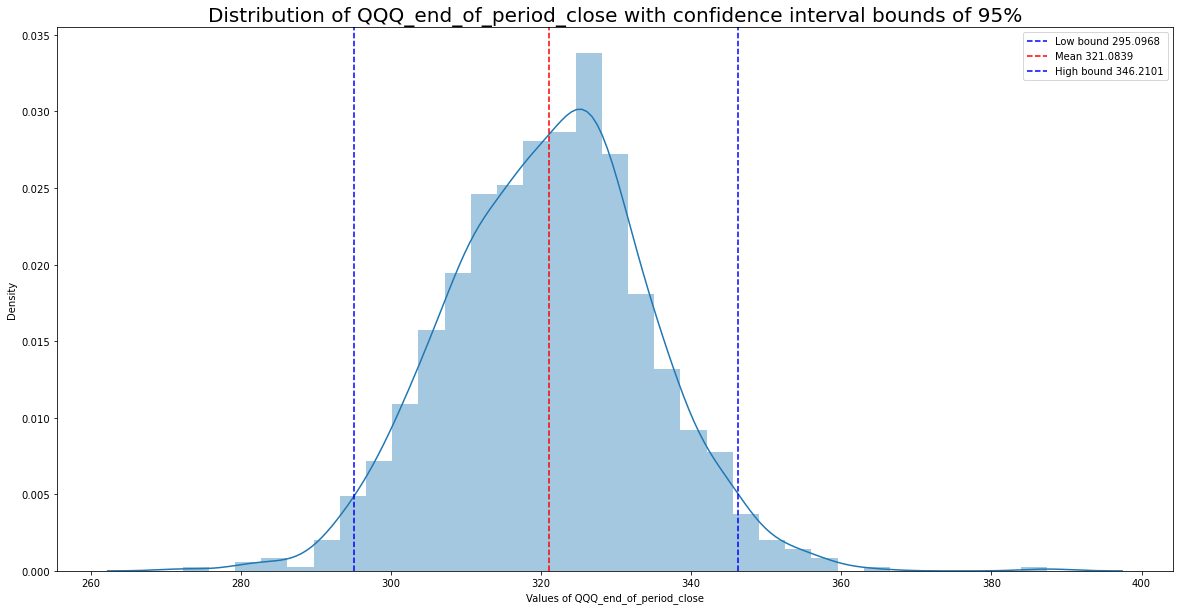

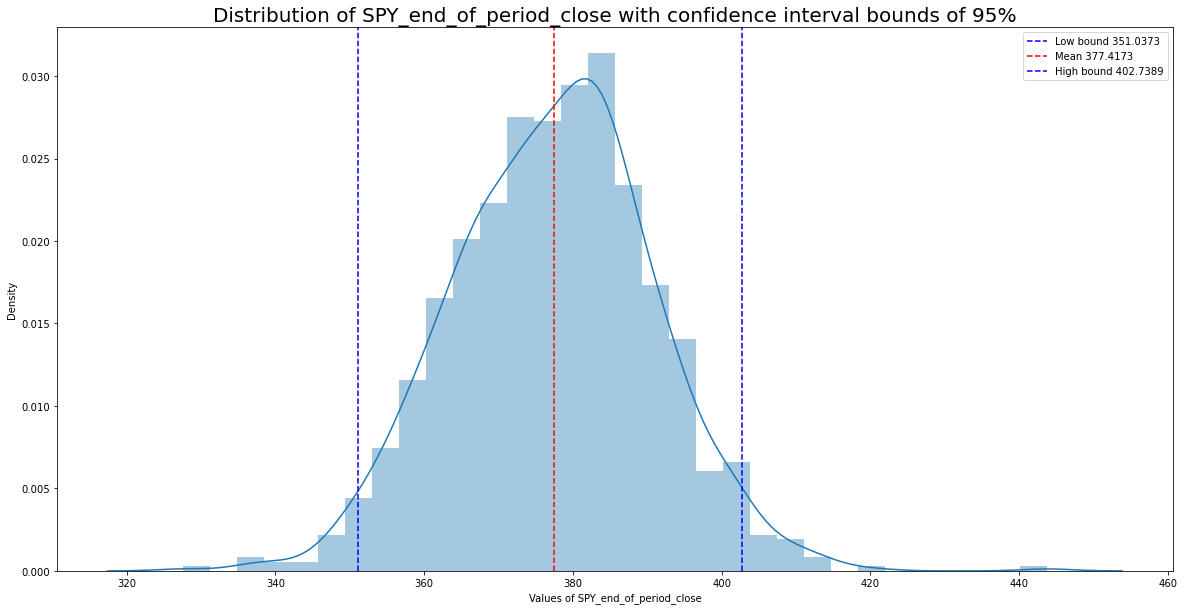

(351.03732649640796, 377.4173235576753, 402.7388720783699)

In [22]:
end_of_period_values = [x[-1] for x in dia_paths]
dt.get_confidence_interval(pd.DataFrame({'DIA_end_of_period_close':end_of_period_values}),  'DIA_end_of_period_close')

end_of_period_values = [x[-1] for x in qqq_paths]
dt.get_confidence_interval(pd.DataFrame({'QQQ_end_of_period_close':end_of_period_values}),  'QQQ_end_of_period_close')


end_of_period_values = [x[-1] for x in spy_paths]
dt.get_confidence_interval(pd.DataFrame({'SPY_end_of_period_close':end_of_period_values}),  'SPY_end_of_period_close')



### Out of Sample Portfolio Predictions

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


Date   Close_DIA   Close_QQQ   Close_SPY  weight_DIA  weight_QQQ  \
0  2020-12-30  304.130005  312.970001  371.989990         0.1         0.8   
1  2020-12-31  304.621831  313.639512  372.581028         0.1         0.8   
2  2021-01-04  304.752189  313.898546  372.752037         0.1         0.8   
3  2021-01-05  304.600188  313.836550  372.594935         0.1         0.8   
4  2021-01-06  303.270725  312.434721  371.069397         0.1         0.8   
5  2021-01-07  303.384631  312.674699  371.221259         0.1         0.8   
6  2021-01-08  304.767364  314.358951  372.848181         0.1         0.8   
7  2021-01-11  303.377117  312.886380  371.251803         0.1         0.8   
8  2021-01-12  303.897803  313.589969  371.876637         0.1         0.8   
9  2021-01-13  304.126329  313.961185  372.161815         0.1         0.8   
10 2021-01-14  305.218642  315.317414  373.451277         0.1         0.8   
11 2021-01-15  306.111418  316.447377  374.508687         0.1         0.8   
12 2021-01-19  306.859928  317.413709  375.398364         0.1         0.8   
13 2021-01-20  308.696458  319.623779  377.552628         0.1         0.8   
14 2021-01-21  308.507496  319.520639  377.352840         0.1         0.8   
15 2021-01-22  308.422046  319.535793  377.273315         0.1         0.8   
16 2021-01-25  308.001420  319.167432  376.804243         0.1         0.8   
17 2021-01-26  308.157572  319.458895  377.005491         0.1         0.8   
18 2021-01-27  307.734730  319.087673  376.533758         0.1         0.8   
19 2021-01-28  307.717017  319.180127  376.532901         0.1         0.8   
20 2021-01-29  306.699484  318.127324  375.369692         0.1         0.8   
21 2021-02-01  304.942472  316.227068  373.346287         0.1         0.8   
22 2021-02-02  301.318675  312.188762  369.150619         0.1         0.8   
23 2021-02-03  301.070579  312.015194  368.881191         0.1         0.8   
24 2021-02-04  302.235047  313.458159  370.256056         0.1         0.8   
25 2021-02-05  302.445011  313.809391  370.519841         0.1         0.8   
26 2021-02-08  301.712051  313.080404  369.686142         0.1         0.8   
27 2021-02-09  302.093132  313.627723  370.149149         0.1         0.8   
28 2021-02-10  302.552405  314.265095  370.703200         0.1         0.8   
29 2021-02-11  304.595494  316.719759  373.100986         0.1         0.8   
30 2021-02-12  304.982236  317.275757  373.570618         0.1         0.8   

    weight_SPY  DIA_num_stocks  QQQ_num_stocks  SPY_num_stocks  \
0          0.1        3.288068       25.561555        2.688244   
1          0.1        3.288068       25.561555        2.688244   
2          0.1        3.288068       25.561555        2.688244   
3          0.1        3.288068       25.561555        2.688244   
4          0.1        3.288068       25.561555        2.688244   
5          0.1        3.288068       25.561555        2.688244   
6          0.1        3.288068       25.561555        2.688244   
7          0.1        3.288068       25.561555        2.688244   
8          0.1        3.288068       25.561555        2.688244   
9          0.1        3.288068       25.561555        2.688244   
10         0.1        3.288068       25.561555        2.688244   
11         0.1        3.288068       25.561555        2.688244   
12         0.1        3.288068       25.561555        2.688244   
13         0.1        3.288068       25.561555        2.688244   
14         0.1        3.288068       25.561555        2.688244   
15         0.1        3.288068       25.561555        2.688244   
16         0.1        3.288068       25.561555        2.688244   
17         0.1        3.288068       25.561555        2.688244   
18         0.1        3.288068       25.561555        2.688244   
19         0.1        3.288068       25.561555        2.688244   
20         0.1        3.288068       25.561555        2.688244   
21         0.1        3.288068       25.561555        2.688244   
22         0.1        3.28

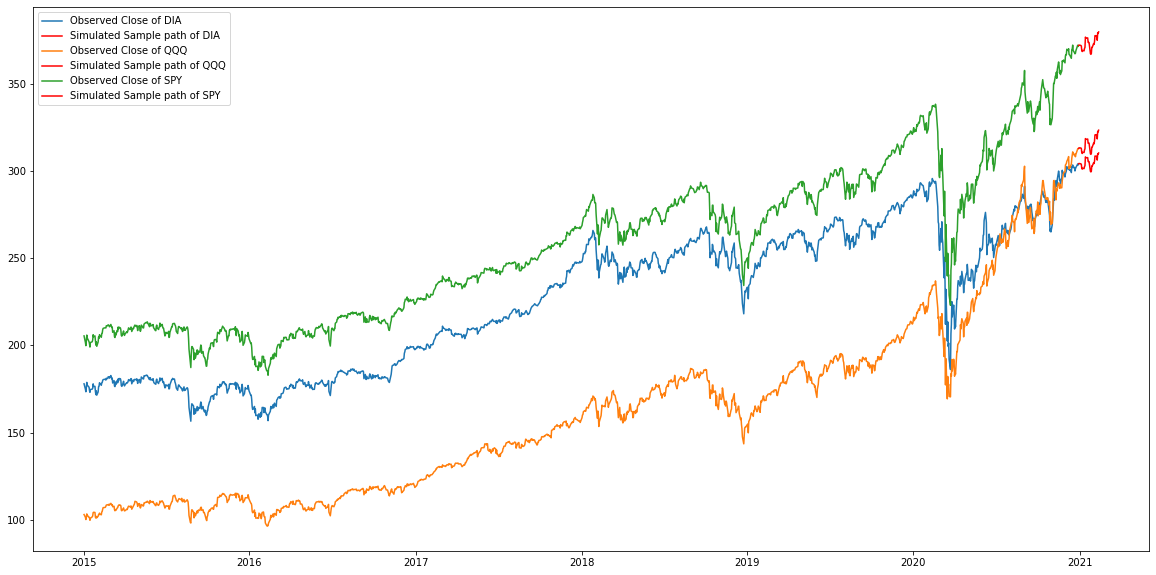

In [23]:
i = 0 

simulated_rebalanced_portfolios = []
for i in range(0,1000): 
    if i%50==0: 
        print(i)
    choice_qqq = qqq_paths[crn_choices[i]]
    choice_dia = dia_paths[crn_choices[i]]
    choice_spy = spy_paths[crn_choices[i]]

    start_date = pd.to_datetime(qqq_df.ticker_data.index)[-1]
    n = len(choice_qqq)
    trading_days = ts.get_trading_days(start_date, n)
    choice_df = pd.DataFrame({'Date':trading_days, 'Close_DIA':choice_dia, 'Close_QQQ':choice_qqq, 'Close_SPY':choice_spy})# trading_days
    choice_df
    simulated_rebalanced_portfolios.append(simulate_portfolio_value(choice_df, best_policy_net_return_adjusted))


plt.figure(figsize=(20,10))

plt.plot(pd.to_datetime(dia_df.ticker_data.index),dia_df.ticker_data['Close'], label='Observed Close of DIA')
plt.plot(choice_df['Date'],choice_df['Close_DIA'], label='Simulated Sample path of DIA', color='red')


plt.plot(pd.to_datetime(qqq_df.ticker_data.index),qqq_df.ticker_data['Close'],label='Observed Close of QQQ')
plt.plot(choice_df['Date'],choice_df['Close_QQQ'],label='Simulated Sample path of QQQ' ,color='red')


plt.plot(pd.to_datetime(spy_df.ticker_data.index),spy_df.ticker_data['Close'], label='Observed Close of SPY')
plt.plot(choice_df['Date'],choice_df['Close_SPY'],label='Simulated Sample path of SPY',color='red')
plt.legend()
    
simulated_rebalanced_portfolios[0]

In [24]:
[simulated_rebalanced_portfolios[0]['portfolio_value'].iloc[-1]

SyntaxError: unexpected EOF while parsing (3241018887.py, line 1)

In [ ]:
### Assuming we have the best policy, we rebalance our portfolio based on that and generate a possible 

crn_choices = [int(x.round(2)*100) for x in common_random_numbers(1000, seed=10)]

simulations_over_month = []

for i in range(0,1000): 
    if i%50==0: 
        print(i)
    choice_dia = dia_paths[crn_choices[i]]
    choice_qqq = qqq_paths[crn_choices[i]]
    choice_spy = spy_paths[crn_choices[i]]

    simulations_over_month.append(get_choice_resource_allocation_df(choice_dia, choice_qqq, choice_spy, num_trading_days=len(choice_dia)))

In [ ]:
# crn_choices = [int(x.round(2)*100) for x in common_random_numbers(100, seed=10)]
i = 0

simulated_rebalanced_portfolio_returns = []
for i in range(0,len(crn_choices)): 
    if i%50==0: 
        print(i)
    choice_qqq = qqq_paths[crn_choices[i]]
    choice_dia = dia_paths[crn_choices[i]]
    choice_spy = spy_paths[crn_choices[i]]

    start_date = pd.to_datetime(qqq_df.ticker_data.index)[-1]
    n = len(choice_qqq)
    trading_days = ts.get_trading_days(start_date, n)
    choice_df = pd.DataFrame({'Date':trading_days, 'Close_DIA':choice_dia, 'Close_QQQ':choice_qqq, 'Close_SPY':choice_spy})# trading_days

    simulated_rebalanced_portfolio_df = simulate_portfolio_value(choice_df, best_policy)
    simulated_rebalanced_portfolio_return = (simulated_rebalanced_portfolio_df['portfolio_value'].iloc[-1]-simulated_rebalanced_portfolio_df['portfolio_value'].iloc[0])/simulated_rebalanced_portfolio_df['portfolio_value'].iloc[0]
    simulated_rebalanced_portfolio_returns.append(simulated_rebalanced_portfolio_return)
    

In [ ]:
# sns.distplot(simulated_rebalanced_portfolio_returns)

# dt.get_confidence_interval(pd.DataFrame({'simulated_rebalanced_portfolio_returns'}) , 'net_return')


In [ ]:
# temp_df

In [ ]:
temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config'] == str(best_policy)]


dt.get_confidence_interval(temp_df , 'net_return')


In [ ]:

dt.get_confidence_interval(pd.DataFrame({'simulated_rebalanced_portfolio_returns':simulated_rebalanced_portfolio_returns}), 'simulated_rebalanced_portfolio_returns')
# sns.distplot(simulated_rebalanced_portfolio_returns, label='Distribution of Returns from Simulated Rebalanced Portfolio')

In [ ]:
temp_df

In [ ]:
temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config']==str(best_policy)]
dt.get_confidence_interval(temp_df,  'net_return')


In [ ]:
temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config']==str(best_policy)]
dt.get_confidence_interval(temp_df,  'VaR')


In [ ]:
temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config']==str(best_policy)]
dt.get_confidence_interval(temp_df,  'cVaR')


In [ ]:
def simulate_portfolio_value(input_df, combination): 

    for i in range(0,len(combination)): 
        input_df[f'weight_{tickers[i]}'] = combination[i]

    for ticker in tickers: 
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    portfolio_values = []
    for i in range(0,len(input_df)): 
        portfolio_value = 0
        for ticker in tickers: 
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    portfolio_values

    input_df['portfolio_value'] = portfolio_values

    return input_df

In [ ]:
sim_df = pd.DataFrame({'date':trading_days, 'Close_QQQ': choice_qqq, 'Close_DIA':choice_dia, 'Close_SPY':choice_spy})
simulated_portfolio_values.append((combinations[i], simulate_portfolio_value(sim_df, combinations[i])['portfolio_value']))


In [ ]:

get_choice_resource_allocation_df(choice_qqq, choice_dia, choice_spy, num_trading_days=len(montecarlo_paths.T)).reset_index().drop(columns='index').style.background_gradient()

In [ ]:
break 

In [ ]:
# import pandas as pd
# import numpy as np
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Assuming you have the following dataframe
# # performance_of_portfolio_configs_df = pd.concat(simulations_over_month)

# alpha = 0.05

# # Prepare the data for the Tukey HSD test
# net_returns = []
# policy_labels = []

# for i in range(len(combinations)):
#     combination_str = str(combinations[i])
#     temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config'] == combination_str]
    
#     net_returns.extend(temp_df['net_return'].tolist())
#     policy_labels.extend([combination_str] * len(temp_df))

# # Perform the Tukey HSD test
# tukey_result = pairwise_tukeyhsd(net_returns, policy_labels, alpha=alpha)

# # Get the list of comparisons with significant differences
# significantly_different_comparisons = [comparison for comparison in tukey_result.reject if comparison]

# # Find the best policy
# best_policy = max(set(policy_labels), key=lambda policy: np.mean([net_returns[i] for i in range(len(net_returns)) if policy_labels[i] == policy]))

# # Identify the subset of "good" policies
# good_policies = [policy for policy in set(policy_labels) if not any([best_policy in comparison and policy in comparison for comparison in significantly_different_comparisons])]

# print("Good policies based on net return:", good_policies)


In [ ]:
best_policy

In [ ]:
dt.get_confidence_interval(pd.DataFrame({'closing price last day':[x[-1] for x in montecarlo_paths]}), 'closing price last day')

In [ ]:
def generate_combinations(step=0.2, target_sum=1.0, num_variables=3, precision=1):
    combinations = []
    num_steps = int(target_sum / step) + 1

    for i in range(num_steps):
        for j in range(num_steps - i):
            k = num_steps - i - j - 1
            if round(i * step, precision) + round(j * step, precision) + round(k * step, precision) == target_sum:
                combinations.append((round(i * step, precision), round(j * step, precision), round(k * step, precision)))

    return combinations

combinations = generate_combinations()
print(combinations)

combinations_df = pd.DataFrame(combinations, columns=tickers)
combinations_df


In [ ]:
initial_budget =10000

def simulate_portfolio_value(input_df, combination): 

    for i in range(0,len(combination)): 
        input_df[f'weight_{tickers[i]}'] = combination[i]

    for ticker in tickers: 
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    portfolio_values = []
    for i in range(0,len(input_df)): 
        portfolio_value = 0
        for ticker in tickers: 
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    portfolio_values

    input_df['portfolio_value'] = portfolio_values

    return input_df

In [ ]:
combinations[0]

In [ ]:
simulate_portfolio_value(merged_df.iloc[1:], (combinations[1]))

In [ ]:
# plt.figure(figsize=(20,10))

# simulated_portfolio_values = []
# for i in range(0,len(combinations)): 
#     simulated_portfolio_values.append((combinations[i], simulate_portfolio_value(merged_df, combinations[i])['portfolio_value']))
# simulated_portfolio_values

# for i in range(0,len(simulated_portfolio_values)): 
#     plt.plot(pd.to_datetime(simulated_portfolio_values[i][1].index), simulated_portfolio_values[i][1].values, label=str(simulated_portfolio_values[i][0]))
    
    
# plt.axhline(y=10000, color='r',  ls='--', label=f'simulated initial budget of ${initial_budget}')

# plt.legend(loc='upper right', title='Weights for dia, SPY and QQQ resp.', bbox_to_anchor=(1.2, 1.0))
# plt.xticks(rotation=90)
# plt.title(f"Simulation of portfolio value under different weights for stocks dia, SPY and QQQ from {start_dt} to {end_dt}", fontsize=20)
# plt.xlabel("Trading Date")
# plt.ylabel("Portfolio Value in USD $")

